In [1]:
print("Kaggle session is alive ✅")


Kaggle session is alive ✅


In [1]:
# Cell 0A: Install Albumentations
!pip install -q albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
print("Albumentations installed and imported.")

Albumentations installed and imported.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



Attempting to load CSV from: /kaggle/input/data/Data_Entry_2017.csv
Successfully loaded CSV. Number of records: 112120
Number of records after filtering for PA/AP views: 112120 (removed 0 rows).
'Finding Labels' NaNs filled and column converted to string.

Defined 'disease_list_for_eda' with 13 labels for initial analysis.
Creating temporary one-hot encoded columns for EDA plot...
Temporary one-hot columns created.

Disease Label Counts (from initial EDA processing):


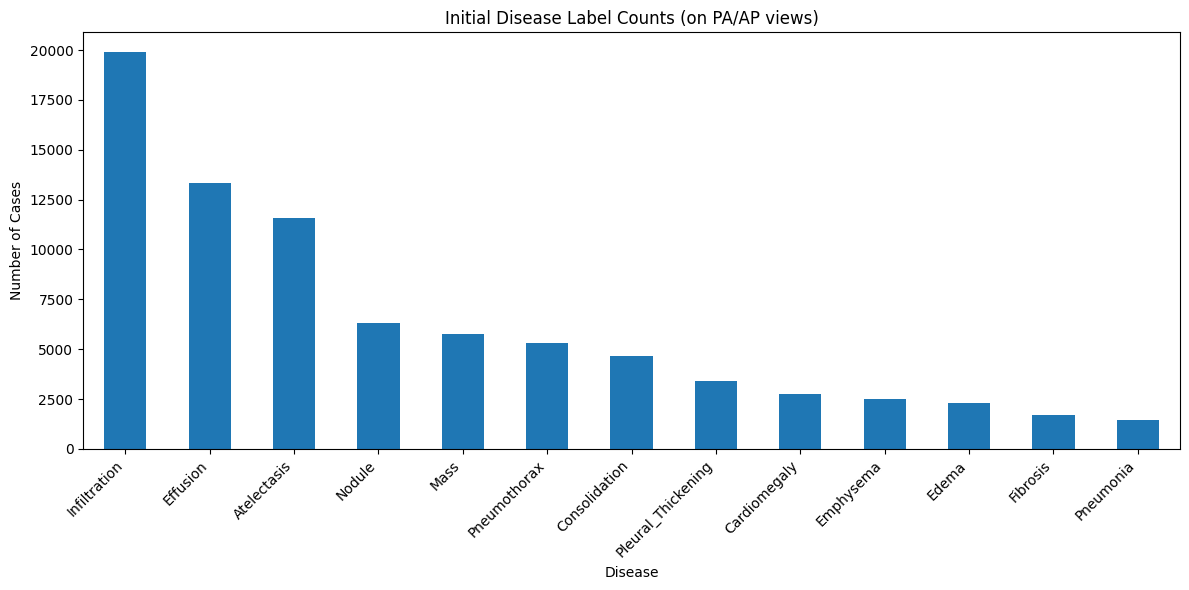


Sample of DataFrame with temporary binary disease columns:
        Image Index          Finding Labels  Atelectasis  Cardiomegaly  \
0  00000001_000.png            Cardiomegaly            0             1   
1  00000001_001.png  Cardiomegaly|Emphysema            0             1   
2  00000001_002.png   Cardiomegaly|Effusion            0             1   
3  00000002_000.png              No Finding            0             0   
4  00000003_000.png                  Hernia            0             0   

   Effusion  Infiltration  Mass  Nodule  Pneumonia  Pneumothorax  \
0         0             0     0       0          0             0   
1         0             0     0       0          0             0   
2         1             0     0       0          0             0   
3         0             0     0       0          0             0   
4         0             0     0       0          0             0   

   Consolidation  Edema  Emphysema  Fibrosis  Pleural_Thickening  
0              0   

In [2]:
# Phase 1: Initial Setup and Data Loading/Preprocessing
# Cell 1: Basic Imports and Initial Data Preparation

# Basic Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns # Not used in this cell, keep if used later
# import cv2 # Not used in this cell, keep if used later
# from PIL import Image # Not used in this cell, keep if used later
# from pathlib import Path # Not used in this cell, keep if used later

# --- Section for listing all files REMOVED for brevity ---
# You can add a limited print loop here if you still want to see a few example paths,
# but the full listing is unnecessary now that your paths are established.
# print("File path verification step (os.walk) has been removed for faster execution.")

# --- Load CSV (Meta information) ---
# Ensure this path is correct based on your Kaggle dataset structure
data_path = "/kaggle/input/data/"
csv_file_name = "Data_Entry_2017.csv"
csv_file_path = os.path.join(data_path, csv_file_name)

print(f"\nAttempting to load CSV from: {csv_file_path}")

if not os.path.exists(csv_file_path):
    print(f"ERROR: CSV file not found at {csv_file_path}. Please verify the path.")
    df = pd.DataFrame() # Create an empty DataFrame to prevent subsequent errors
else:
    df = pd.read_csv(csv_file_path)
    print(f"Successfully loaded CSV. Number of records: {len(df)}")

    # --- Filter to frontal (PA/AP) X-rays only ---
    if 'View Position' in df.columns:
        df_len_before_view_filter = len(df)
        df = df[df['View Position'].isin(['PA', 'AP'])]
        print(f"Number of records after filtering for PA/AP views: {len(df)} (removed {df_len_before_view_filter - len(df)} rows).")
    else:
        print("Warning: 'View Position' column not found. Skipping PA/AP view filtering.")

    # --- Clean 'Finding Labels' (String format for now) ---
    if 'Finding Labels' in df.columns:
        df['Finding Labels'] = df['Finding Labels'].fillna('No Finding').astype(str)
        print("'Finding Labels' NaNs filled and column converted to string.")
    else:
        print("Warning: 'Finding Labels' column not found. Cannot clean this column.")

    # --- Define disease list for initial EDA (This should match Cell 3 & 6 for consistency) ---
    # This list will be used for the preliminary one-hot encoding and plot in this cell.
    # Cell 3 will perform the definitive one-hot encoding on the filtered df.
    disease_list_for_eda = [ # Ensure this list is IDENTICAL to 'final_disease_list' in Cell 3 and 'disease_labels' in Cell 6
        "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass",
        "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", "Edema",
        "Emphysema", "Fibrosis", "Pleural_Thickening" # Corrected to underscore based on previous findings
    ]
    print(f"\nDefined 'disease_list_for_eda' with {len(disease_list_for_eda)} labels for initial analysis.")


    # --- Create multi-label binary columns for EDA plot (will be re-done definitively in Cell 3) ---
    if 'Finding Labels' in df.columns:
        print("Creating temporary one-hot encoded columns for EDA plot...")
        for disease in disease_list_for_eda:
            # This lambda works correctly if df['Finding Labels'] is a string like "A|B"
            # because 'in' performs a substring check.
            df[disease] = df['Finding Labels'].apply(lambda x_str: 1 if disease in x_str else 0)
        print("Temporary one-hot columns created.")

        # --- Show label distribution (EDA) ---
        if not df.empty and all(disease in df.columns for disease in disease_list_for_eda):
            print("\nDisease Label Counts (from initial EDA processing):")
            df[disease_list_for_eda].sum().sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
            plt.title("Initial Disease Label Counts (on PA/AP views)")
            plt.ylabel("Number of Cases")
            plt.xlabel("Disease")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

            # --- Display a sample of the dataframe with new columns ---
            print("\nSample of DataFrame with temporary binary disease columns:")
            columns_to_show_sample = ['Image Index', 'Finding Labels'] + disease_list_for_eda
            # Ensure all columns exist before trying to display them
            existing_cols_for_sample = [col for col in columns_to_show_sample if col in df.columns]
            print(df[existing_cols_for_sample].head())
        else:
            print("Skipping EDA plot/sample display as DataFrame is empty or one-hot columns not created.")
    else:
        print("Skipping creation of temporary one-hot columns and EDA plot as 'Finding Labels' column is missing.")

if df.empty:
    print("\nWARNING: DataFrame 'df' is empty after initial processing in Cell 1. Subsequent cells may fail.")

In [3]:
# New Cell (e.g., after initial imports in Cell 1)
!pip install -q torchxrayvision

In [4]:
# Cell 2: Disease Frequency Analysis from 'Finding Labels' String

# --- DEBUGGING START ---
print("Current DataFrame columns in Cell 2:")
if 'df' in locals() and isinstance(df, pd.DataFrame):
    print(df.columns)
    print("\nFirst 5 rows of df in Cell 2:")
    print(df.head())
else:
    print("'df' is not defined or is not a DataFrame in Cell 2.")
# --- DEBUGGING END ---

from collections import Counter
# pandas as pd is likely already imported, and 'df' is available from Cell 1

# Assuming 'df' is the DataFrame that was processed by Cell 1.
# In Cell 1, df['Finding Labels'] was converted to a string column
# where multiple findings are separated by '|' (e.g., "Disease1|Disease2" or "No Finding").

# 1. Create a list to hold all individual label mentions
all_individual_labels = []

# 2. Iterate through the 'Finding Labels' column
# Add a check here as well
if 'Finding Labels' in df.columns:
    for label_string in df['Finding Labels']:
        # Split the string by '|' to get individual labels
        # For example, "Atelectasis|Effusion" becomes ['Atelectasis', 'Effusion']
        # "No Finding" becomes ['No Finding']
        individual_labels_in_row = label_string.split('|')
        # Add these labels to our main list
        all_individual_labels.extend(individual_labels_in_row)

    # 3. Count occurrences of each unique label
    label_counts_from_string = Counter(all_individual_labels)

    # 4. Display the frequencies
    print("\nFrequency of all unique labels mentioned in 'Finding Labels' column (after splitting by '|'):")
    for disease, count in label_counts_from_string.most_common():
        print(f"{disease}: {count}")
else:
    print("\nERROR in Cell 2: 'Finding Labels' column not found in df.")
    if 'df' in locals() and isinstance(df, pd.DataFrame):
        print("Available columns are:", df.columns)

Current DataFrame columns in Cell 2:
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
       'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
       'Emphysema', 'Fibrosis', 'Pleural_Thickening'],
      dtype='object')

First 5 rows of df in Cell 2:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImag

In [5]:
# Cell 3: Process for 14 Target Diseases and Keep "No Finding" Images

from collections import Counter
import pandas as pd

# --- Step 1: Define the NEW definitive list of target diseases ---
# We are adding 'Hernia' to our list of pathologies to detect.
final_disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia' # Added Hernia
]
# We will handle "No Finding" as a separate special column.
print(f"Targeting {len(final_disease_list)} diseases for multi-label classification: {final_disease_list}")

print(f"\nDataFrame size before Cell 3 processing: {len(df)}")

# --- Step 2: Ensure 'Finding Labels' is string type, then split into a list of labels ---
if 'Finding Labels' not in df.columns:
    print("ERROR: 'Finding Labels' column not found. Did Cell 1 run correctly?")
else:
    # This logic from your previous cell is good and remains.
    df['Finding Labels'] = df['Finding Labels'].fillna('No Finding').astype(str)
    df['Finding Labels (list)'] = df['Finding Labels'].str.split('|')
    print("Processed 'Finding Labels' into string and list formats.")

    # --- Step 3: Multi-hot encode the target diseases AND the 'No Finding' status ---
    if 'Finding Labels (list)' in df.columns:
        print("\nCreating multi-hot encoded columns for all target diseases...")
        
        # Create binary columns for the 14 pathologies
        for disease in final_disease_list:
            df[disease] = df['Finding Labels (list)'].apply(lambda labels_list: 1 if disease in labels_list else 0)
        
        # Create a specific column for the 'No Finding' label
        # This will be 1 only if the label list is exactly ['No Finding']
        df['No_Finding'] = df['Finding Labels (list)'].apply(lambda labels_list: 1 if labels_list == ['No Finding'] else 0)
        
        print("Multi-hot encoding complete for 14 diseases + 'No_Finding' status.")

        # --- IMPORTANT: We are REMOVING the old filtering step (your previous Step 4) ---
        # By not filtering, we keep ALL images, including those with "No Finding".
        # This significantly increases the dataset size for training.
        print("\nSkipping filtering step to include all images, including 'No Finding' cases.")

        # Let's create a final list of all label columns we will use.
        all_label_columns = final_disease_list + ['No_Finding']

        # --- Step 4: Sanity Check (replaces your old Step 6) ---
        # This check ensures that every row has at least one '1' in our new set of 15 label columns.
        # (Either one of the 14 diseases is present, or the 'No_Finding' flag is 1).
        df['label_sum_check'] = df[all_label_columns].sum(axis=1)
        
        # Find rows where the sum is 0. This should only happen for very rare, unlisted diseases
        # that are not 'No Finding' (e.g., if a row was just 'Subcutaneous Emphysema').
        problematic_rows = df[df['label_sum_check'] == 0]
        if not problematic_rows.empty:
            print(f"\nWARNING: Found {len(problematic_rows)} rows that are not 'No Finding' but have none of the 14 target diseases.")
            print("         These rows will have all-zero labels. Example problematic labels:", problematic_rows['Finding Labels'].head().tolist())
        else:
            print("\nSanity check passed: All rows are either 'No Finding' or have at least one of the 14 target diseases.")

    else:
        print("Skipping multi-hot encoding as 'Finding Labels (list)' was not created.")

    print(f"\n✅ Final dataset size for Cell 3 (all PA/AP images included): {len(df)}")

    # Display a sample of the dataframe with new columns
    if not df.empty:
        print("\nSample of DataFrame after Cell 3 processing:")
        # Show the newly added 'Hernia' and 'No_Finding' columns
        columns_to_show = ['Image Index', 'Finding Labels (list)'] + all_label_columns
        existing_columns_to_show = [col for col in columns_to_show if col in df.columns]
        print(df[existing_columns_to_show].head())
    else:
        print("\nDataFrame is empty. No sample to show.")

Targeting 14 diseases for multi-label classification: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

DataFrame size before Cell 3 processing: 112120
Processed 'Finding Labels' into string and list formats.

Creating multi-hot encoded columns for all target diseases...
Multi-hot encoding complete for 14 diseases + 'No_Finding' status.

Skipping filtering step to include all images, including 'No Finding' cases.

Sanity check passed: All rows are either 'No Finding' or have at least one of the 14 target diseases.

✅ Final dataset size for Cell 3 (all PA/AP images included): 112120

Sample of DataFrame after Cell 3 processing:
        Image Index      Finding Labels (list)  Atelectasis  Cardiomegaly  \
0  00000001_000.png             [Cardiomegaly]            0             1   
1  00000001_001.png  [Cardiomegaly, Emphysema]            0           

In [6]:
# Cell 4: Image Path Mapping
import os
from glob import glob

# Step 1: Recursively collect all image paths
all_image_paths = glob("/kaggle/input/data/images_*/images/*.png")

# Step 2: Map filename to full path
image_path_map = {os.path.basename(path): path for path in all_image_paths}

# Step 3: Match each image in the DataFrame to its full path
df["full_path"] = df["Image Index"].map(image_path_map)

# Check if any paths are missing (should be 0 ideally)
missing_count = df["full_path"].isnull().sum()
print(f"Missing images: {missing_count}")


Missing images: 0


In [7]:
# Cell 4A: Filter DataFrame by Valid Image Paths (with Optional Switch)

import os
import pandas as pd
import time # Import time to measure duration

# --- THIS IS THE NEW CONTROL SWITCH ---
# Set to True for a full, robust check (takes ~5 mins).
# Set to False to skip this check and save time if you are confident the paths are valid.
RUN_PATH_VALIDATION_CHECK = False
# ---

if not RUN_PATH_VALIDATION_CHECK:
    print("ℹ️ Path validation check skipped as per 'RUN_PATH_VALIDATION_CHECK' setting.")
else:
    # --- The rest of your existing Cell 4A code goes inside this else block ---
    path_column_name = None
    if 'df' in locals() and not df.empty:
        if 'full_path' in df.columns:
            path_column_name = 'full_path'
        elif 'Image Path' in df.columns:
            path_column_name = 'Image Path'

    if 'df' in locals() and not df.empty and path_column_name is not None:
        print(f"--- Running Path Validation (this may take a few minutes) ---")
        print(f"Using column '{path_column_name}' for checking image path validity.")
        print(f"DataFrame size before path validation filtering: {len(df)}")
        
        start_time = time.time()

        def is_valid_image_file(image_path_to_check):
            if pd.isna(image_path_to_check) or not isinstance(image_path_to_check, str):
                return False
            return os.path.exists(image_path_to_check) and os.path.isfile(image_path_to_check)

        is_valid_series = df[path_column_name].apply(is_valid_image_file)
        num_invalid_paths_found = (~is_valid_series).sum()

        end_time = time.time()
        print(f"Path validation completed in {end_time - start_time:.2f} seconds.")

        if num_invalid_paths_found > 0:
            print(f"Found {num_invalid_paths_found} invalid image paths. These rows will be removed.")
            df = df[is_valid_series].copy()
            print(f"✅ Number of samples in 'df' after path validation: {len(df)}")
            print("\nWARNING: Rows were removed from 'df'. Subsequent cells will use this smaller DataFrame.")
        else:
            print("All image paths in the DataFrame point to valid, existing files. No rows removed.")
            print(f"✅ Valid samples after path checking: {len(df)}")

        final_missing_mapped_paths = df[path_column_name].isnull().sum()
        print(f"Post-filter check: Number of null values in '{path_column_name}': {final_missing_mapped_paths}")

    elif 'df' in locals() and not df.empty and path_column_name is None:
        print(f"ERROR: Image path column ('full_path' or 'Image Path') not found.")
    else:
        print("ERROR: DataFrame 'df' is not defined or is empty.")

ℹ️ Path validation check skipped as per 'RUN_PATH_VALIDATION_CHECK' setting.


Testing path: /kaggle/input/data/images_001/images/00000001_000.png


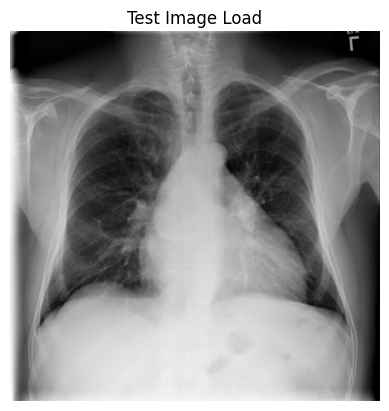

In [8]:
# Phase 2: PyTorch Dataset and DataLoader Setup
# Cell 5: Test Single Image Loading
from PIL import Image
import matplotlib.pyplot as plt

# Just load one known image path to test
sample_path = df["full_path"].iloc[0]
print("Testing path:", sample_path)

try:
    img = Image.open(sample_path).convert("L")
    plt.imshow(img, cmap="gray")
    plt.title("Test Image Load")
    plt.axis("off")
    plt.show()
except Exception as e:
    print("Error loading image:", e)


In [9]:
# Cell 6: Define 14 Target Disease Labels

# This list MUST now match the new 14-disease list from Cell 3.
disease_labels = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia' # Added Hernia
]
print(f"Target disease labels set for the model: {len(disease_labels)} labels.")
print(disease_labels)

# Optional check against df columns
if 'df' in locals():
    missing_cols = [label for label in disease_labels if label not in df.columns]
    if not missing_cols:
        print("\nAll defined disease labels are present as columns in the DataFrame.")
    else:
        print(f"\nWARNING: The following labels are NOT columns in the DataFrame: {missing_cols}")

Target disease labels set for the model: 14 labels.
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

All defined disease labels are present as columns in the DataFrame.


In [10]:
# Cell 7: Advanced Augmentation (with Definitive Preprocessing Fix)

import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchxrayvision as xrv

# --- 1. Define Advanced Transforms with Albumentations ---
# This part of your code is correct and will remain.
IMG_SIZE = 224

train_transform = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.7),
    ToTensorV2()
])
print("\nTrain transform (fully self-contained Albumentations pipeline) defined.")

val_transform = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    ToTensorV2()
])
print("Validation transform (fully self-contained Albumentations pipeline) defined.")


# --- 2. Update the ChestXrayDataset Class ---
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, disease_labels_list, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.image_paths = self.df['full_path'].values
        self.labels = self.df[disease_labels_list].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if image is None:
                raise IOError(f"cv2.imread failed for path: {img_path}")
            
            if self.transform:
                augmented = self.transform(image=image)
                image_tensor = augmented['image']
            else:
                image_tensor = torch.from_numpy(image)
            
            # --- THIS IS THE DEFINITIVE FIX, ADDED BACK ---
            # The debug cell proved image_tensor is torch.uint8 [0, 255].
            # We MUST manually convert it to a FloatTensor and scale it to [0, 1].
            
            # 1. Convert data type to float32
            image_tensor = image_tensor.float()
            
            # 2. Scale values from [0, 255] to [0, 1]
            image_tensor = image_tensor / 255.0
            
            # 3. Ensure channel dimension exists: [H, W] -> [C, H, W]
            if image_tensor.ndim == 2:
                image_tensor = image_tensor.unsqueeze(0)
            # --- END OF DEFINITIVE FIX ---

            label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)
            
            return image_tensor, label_tensor
            
        except Exception as e:
            print(f"ERROR in __getitem__ for image path {img_path}: {e}")
            return None, None

print("\n✅ ChestXrayDataset class (with definitive preprocessing fix) and new transforms are ready.")


Train transform (fully self-contained Albumentations pipeline) defined.
Validation transform (fully self-contained Albumentations pipeline) defined.

✅ ChestXrayDataset class (with definitive preprocessing fix) and new transforms are ready.


In [11]:
# Cell 8: Custom Collate Function

from torch.utils.data.dataloader import default_collate
# No other imports needed for this specific function definition.

def collate_fn_skip_none(batch): # Renamed for clarity of its action
    """
    Custom collate_fn that filters out None items from a batch.
    These Nones might arise from errors during image loading in __getitem__.
    """
    # Filter out samples that are None (e.g., due to loading errors in __getitem__)
    original_batch_size = len(batch)
    batch = [item for item in batch if item is not None and item[0] is not None and item[1] is not None]
    # The check 'item is not None' handles if __getitem__ returns a single None.
    # The 'item[0] is not None and item[1] is not None' handles if __getitem__ returns (None, None) or (Tensor, None) etc.

    filtered_count = original_batch_size - len(batch)
    if filtered_count > 0:
        print(f"Collate_fn: Filtered out {filtered_count} None sample(s) from a batch of size {original_batch_size}.")

    # If the entire batch was filtered out (e.g., all images in this batch were problematic)
    if not batch: # Check if batch is empty
        # Returning None will cause the training loop to skip this batch.
        # The training loop needs to be able to handle this (e.g., `if batch_data is None: continue`).
        print("Collate_fn: Entire batch was filtered out. Returning None for this batch.")
        return None

    # If there are valid samples left, use the default collate function to stack them
    try:
        return default_collate(batch)
    except Exception as e:
        print(f"Collate_fn: Error during default_collate after filtering. Error: {e}")
        # This could happen if, despite filtering, items have inconsistent shapes or types that default_collate can't handle.
        # For debugging, you might want to inspect the 'batch' here.
        # for i, item in enumerate(batch):
        #    print(f"Item {i} in problematic batch: Image shape {item[0].shape if item[0] is not None else 'None'}, Label {item[1] if item[1] is not None else 'None'}")
        return None # Or raise the error to halt and debug

print("✅ Custom collate_fn (collate_fn_skip_none) is ready.")

✅ Custom collate_fn (collate_fn_skip_none) is ready.


In [12]:
# Cell 8A: Patient-Level Data Splitting and Dataset Creation (Corrected)

from sklearn.model_selection import GroupShuffleSplit
import pandas as pd

# --- Configuration for Data Splitting ---
VAL_SIZE = 0.2
RANDOM_STATE = 42

# --- Verify Prerequisites ---
# The check for 'xray_preprocess' is no longer needed here.
if 'df' not in locals() or df.empty:
    print("ERROR: DataFrame 'df' is not defined or is empty.")
elif 'Patient ID' not in df.columns:
    print("ERROR: 'Patient ID' column not found in DataFrame.")
elif 'disease_labels' not in globals():
    print("ERROR: 'disease_labels' list is not defined.")
elif 'train_transform' not in globals() or 'val_transform' not in globals():
    print("ERROR: 'train_transform' or 'val_transform' not defined (from Cell 7).")
elif 'ChestXrayDataset' not in globals() or not callable(ChestXrayDataset):
    print("ERROR: 'ChestXrayDataset' class is not defined or not callable.")
else:
    print(f"Original DataFrame size: {len(df)} images from {df['Patient ID'].nunique()} unique patients.")

    # --- Patient-Level Splitting using GroupShuffleSplit ---
    print("\nPerforming patient-level split to prevent data leakage...")
    groups = df['Patient ID']
    gss = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_STATE)
    train_idx, val_idx = next(gss.split(df, groups=groups))
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    
    # --- Verification of the Split ---
    train_patients = set(train_df['Patient ID'])
    val_patients = set(val_df['Patient ID'])
    if not train_patients.intersection(val_patients):
        print("✅ Patient-level split successful. No patient data leakage detected.")
    else:
        print(f"❌ WARNING: Data leakage detected!")

    print(f"\nTraining set: {len(train_df)} images from {train_df['Patient ID'].nunique()} unique patients.")
    print(f"Validation set: {len(val_df)} images from {val_df['Patient ID'].nunique()} unique patients.")

    # --- Instantiate Dataset objects ---
    # --- THIS IS THE KEY CHANGE ---
    # The constructor is now simpler and only takes the 'transform' argument.
    print("\nInstantiating train_dataset with the new train_transform...")
    train_dataset = ChestXrayDataset(
        dataframe=train_df,
        disease_labels_list=disease_labels,
        transform=train_transform # The full Albumentations pipeline from Cell 7
    )

    print("Instantiating val_dataset with the new val_transform...")
    val_dataset = ChestXrayDataset(
        dataframe=val_df,
        disease_labels_list=disease_labels,
        transform=val_transform # The full Albumentations pipeline for validation from Cell 7
    )
    # --- END OF KEY CHANGE ---

    print("\n✅ train_dataset and val_dataset created successfully.")

Original DataFrame size: 112120 images from 30805 unique patients.

Performing patient-level split to prevent data leakage...
✅ Patient-level split successful. No patient data leakage detected.

Training set: 89826 images from 24644 unique patients.
Validation set: 22294 images from 6161 unique patients.

Instantiating train_dataset with the new train_transform...
Instantiating val_dataset with the new val_transform...

✅ train_dataset and val_dataset created successfully.


In [13]:
# Cell 9: Create DataLoaders (with Parallel Loading Re-enabled)

from torch.utils.data import DataLoader
# Assumes 'train_dataset' and 'val_dataset' are defined from Cell 8A.
# Assumes 'collate_fn_skip_none' is defined from Cell 8.

# --- Configuration ---
BATCH_SIZE = 64 # Keep this as high as your GPU memory allows
VAL_BATCH_SIZE = BATCH_SIZE * 2 # e.g., 128

# --- KEY CHANGE: RE-ENABLE PARALLEL LOADING ---
# This will use background processes to load data, which is much faster.
NUM_WORKERS = 2  # 2 is a standard, safe number for Kaggle environments.
# --- END OF KEY CHANGE ---

PIN_MEMORY = True # Good for GPU training

# --- Verify Prerequisites ---
if 'train_dataset' not in locals() or 'val_dataset' not in locals() or 'collate_fn_skip_none' not in locals():
    print("ERROR: One or more prerequisites (train_dataset, val_dataset, collate_fn) are missing.")
else:
    print(f"Found train_dataset with {len(train_dataset)} samples.")
    print(f"Found val_dataset with {len(val_dataset)} samples.")
    print(f"Using collate function: {collate_fn_skip_none.__name__}")

    # --- Create DataLoaders ---
    print(f"\nCreating DataLoader for train_dataset with batch size {BATCH_SIZE} and {NUM_WORKERS} workers...")
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS, # Using parallel workers
        collate_fn=collate_fn_skip_none,
        pin_memory=PIN_MEMORY,
        drop_last=True
    )

    print(f"Creating DataLoader for val_dataset with batch size {VAL_BATCH_SIZE} and {NUM_WORKERS} workers...")
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=VAL_BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS, # Using parallel workers
        collate_fn=collate_fn_skip_none,
        pin_memory=PIN_MEMORY,
        drop_last=False
    )

    print("\n✅ DataLoaders are ready (with parallel loading enabled).")

    # --- Quick Check: Number of Batches ---
    num_train_batches = len(train_loader)
    num_val_batches = len(val_loader)
    print(f"Number of batches in train_loader: {num_train_batches}")
    print(f"Number of batches in val_loader: {num_val_batches}")

    # --- Safer Test for Fetching a Batch ---
    # This test is sometimes unstable with num_workers>0 in notebooks.
    # The main training loop is usually more stable. We can keep this test
    # but be aware that if it fails, the training loop might still work.
    print("\n--- Testing DataLoaders: Attempting to fetch one batch from each ---")
    
    try:
        print("Fetching first batch from train_loader...")
        train_batch_sample = next(iter(train_loader))
        if train_batch_sample is not None:
            train_images, train_labels = train_batch_sample
            print(f"  Successfully fetched train batch.")
            print(f"  Train batch images shape: {train_images.shape}")
            print(f"  Train batch labels shape: {train_labels.shape}")
        else:
            print("  WARNING: First batch from train_loader was None.")
    except Exception as e:
        print(f"  WARNING: Could not fetch a test batch from train_loader (Error: {e}).")
        print("           This can sometimes happen in notebooks. The main training loop might still work.")

    try:
        print("Fetching first batch from val_loader...")
        val_batch_sample = next(iter(val_loader))
        if val_batch_sample is not None:
            val_images, val_labels = val_batch_sample
            print(f"  Successfully fetched validation batch.")
            print(f"  Validation batch images shape: {val_images.shape}")
            print(f"  Validation batch labels shape: {val_labels.shape}")
        else:
            print("  WARNING: First batch from val_loader was None.")
    except Exception as e:
        print(f"  WARNING: Could not fetch a test batch from val_loader (Error: {e}).")

Found train_dataset with 89826 samples.
Found val_dataset with 22294 samples.
Using collate function: collate_fn_skip_none

Creating DataLoader for train_dataset with batch size 64 and 2 workers...
Creating DataLoader for val_dataset with batch size 128 and 2 workers...

✅ DataLoaders are ready (with parallel loading enabled).
Number of batches in train_loader: 1403
Number of batches in val_loader: 175

--- Testing DataLoaders: Attempting to fetch one batch from each ---
Fetching first batch from train_loader...
  Successfully fetched train batch.
  Train batch images shape: torch.Size([64, 1, 224, 224])
  Train batch labels shape: torch.Size([64, 14])
Fetching first batch from val_loader...
  Successfully fetched validation batch.
  Validation batch images shape: torch.Size([128, 1, 224, 224])
  Validation batch labels shape: torch.Size([128, 14])


In [14]:
# Cell 10: Define and Optionally Load Final Model

import torch
import torch.nn as nn
import torchxrayvision as xrv
import os
from collections import OrderedDict

# --- 1. Define the Final Model Architecture ---
# This version includes your configurable dropout rate.
class ChestXrayModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.6):
        super(ChestXrayModel, self).__init__()
        self.backbone = xrv.models.DenseNet(weights="densenet121-res224-all")
        self.backbone.op_threshs = None
        
        num_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        
        self.head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate), # Using the configurable rate
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

# --- 2. Configuration ---
# 'disease_labels' from Cell 6 determines the number of classes.
if 'disease_labels' not in globals():
    print("ERROR: 'disease_labels' list is not defined.")
    model = None # Set model to None to prevent errors
else:
    num_actual_classes = len(disease_labels)
    DROPOUT_RATE_FOR_RUN = 0.6 # Configure the dropout rate here
    
    # OPTIONAL: Path to a previously saved champion model to start from.
    # If this file doesn't exist or the path is empty, the model will train from base torchxrayvision weights.
    PREVIOUS_CHAMPION_CHECKPOINT = '/kaggle/input/latest5/best_model_all_out_v1.pth'

    # --- 3. Create the model instance ---
    print(f"--- Initializing Model ---")
    print(f"Creating model architecture for {num_actual_classes} classes with dropout rate {DROPOUT_RATE_FOR_RUN}...")
    model = ChestXrayModel(
        num_classes=num_actual_classes,
        dropout_rate=DROPOUT_RATE_FOR_RUN
    )

    # --- 4. Load weights IF AVAILABLE ---
    if os.path.exists(PREVIOUS_CHAMPION_CHECKPOINT):
        print(f"\nFound previous champion checkpoint at '{PREVIOUS_CHAMPION_CHECKPOINT}'.")
        print("Loading its weights into the current model...")
        try:
            checkpoint = torch.load(PREVIOUS_CHAMPION_CHECKPOINT, map_location=torch.device('cpu'), weights_only=False)
            old_state_dict = checkpoint['model_state_dict']
            
            # The name remapping logic to handle 'base_model' vs 'backbone'/'head'
            renamed_state_dict = OrderedDict()
            for old_key, weights in old_state_dict.items():
                new_key = old_key.replace('base_model.classifier', 'head').replace('base_model', 'backbone')
                renamed_state_dict[new_key] = weights
            
            model.load_state_dict(renamed_state_dict, strict=False)
            print("✅ Weight transfer successful.")
            
            loaded_epoch = checkpoint.get('epoch', 'N/A')
            loaded_auc = checkpoint.get('best_metric_value', 'N/A')
            print(f"   Model is now initialized with knowledge from epoch {loaded_epoch} (AUC {loaded_auc:.4f}).")
        except Exception as e:
            print(f"   ❌ WARNING: Could not load weights from checkpoint. Error: {e}")
            print("      Proceeding with the base torchxrayvision weights.")
    else:
        print("\nNo previous champion checkpoint found or specified.")
        print("✅ Model initialized with base torchxrayvision weights, ready for a fresh training run.")

--- Initializing Model ---
Creating model architecture for 14 classes with dropout rate 0.6...

Found previous champion checkpoint at '/kaggle/input/latest4/best_model_all_out_v1.pth'.
Loading its weights into the current model...
✅ Weight transfer successful.
   Model is now initialized with knowledge from epoch 20 (AUC 0.8470).


In [15]:
# Cell 11: Final Advanced Setup (Focal Loss, Discriminative LR, OneCycleLR)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler

# --- 1. Define the Focal Loss Class ---
# This will now be our primary loss function.
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        if self.reduction == 'mean': return torch.mean(F_loss)
        elif self.reduction == 'sum': return torch.sum(F_loss)
        else: return F_loss

print("FocalLoss class defined.")

# --- 2. Define the Setup Function ---
def setup_optimizer_and_scheduler(model, train_loader, total_epochs):
    """
    Sets up the advanced optimizer, scheduler, and GradScaler for the model.
    """
    if model is None or train_loader is None:
        print("ERROR: Model or train_loader not provided.")
        return None, None, None, None, None
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    print(f"✅ Model successfully moved to device: {device}")

    # --- Use Focal Loss as the criterion ---
    criterion = FocalLoss()
    print("Using FocalLoss (alpha=0.25, gamma=2.0) as the loss function.")

    # --- Optimizer with Discriminative Learning Rates ---
    # We use a high LR for the new head and a very low LR for the backbone.
    HEAD_LR = 1e-3
    BACKBONE_LR = 1e-5
    optimizer = optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': BACKBONE_LR},
        {'params': model.head.parameters(), 'lr': HEAD_LR}
    ], weight_decay=1e-5) # Added back weight_decay
    print(f"Optimizer: AdamW with Discriminative LR (Backbone: {BACKBONE_LR}, Head: {HEAD_LR}).")

    # --- Learning Rate Scheduler: OneCycleLR ---
    steps_per_epoch = len(train_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=[BACKBONE_LR, HEAD_LR],
        epochs=total_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,
        div_factor=25,
        final_div_factor=1e4
    )
    print(f"Learning Rate Scheduler: OneCycleLR (Total Epochs: {total_epochs}).")

    # Mixed Precision GradScaler
    scaler = GradScaler(enabled=(device.type == 'cuda'))
    print(f"Automatic Mixed Precision (AMP) GradScaler created.")

    print(f"\n✅ All components ready for the final, advanced training run.")
    
    return optimizer, scheduler, criterion, device, scaler

print("\n✅ setup_optimizer_and_scheduler function defined (using FocalLoss and advanced setup).")

FocalLoss class defined.

✅ setup_optimizer_and_scheduler function defined (using FocalLoss and advanced setup).


In [20]:
# Cell 12A: Define Single Epoch Training Function (for Per-Batch Scheduler like OneCycleLR)

import torch
from tqdm import tqdm
from torch.cuda.amp import autocast

# --- Update the function to accept and step the scheduler per batch ---
def train_one_epoch(model, criterion, optimizer, data_loader, device, scaler, scheduler): # ADDED scheduler
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(data_loader, desc="Training Epoch", leave=False)
    
    for batch_idx, batch_data in enumerate(progress_bar):
        if batch_data is None:
            continue
        
        images, labels = batch_data
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision forward pass
        with autocast(enabled=(device.type == 'cuda')):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Scaled backward pass and optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # --- THIS IS THE KEY CHANGE ---
        # Step the OneCycleLR scheduler after every batch
        scheduler.step()
        # --- END OF KEY CHANGE ---

        running_loss += loss.item() * images.size(0)

        # Update progress bar description with current loss and learning rate
        if batch_idx % 20 == 0:
             # Get the LR for the 'head' parameter group (the second group, index 1)
             # which is the more informative one to track during the cycle.
             current_head_lr = scheduler.get_last_lr()[1]
             progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'head_lr': f'{current_head_lr:.1e}'})
             
    progress_bar.close()
    
    # Logic for calculating epoch loss is fine
    num_samples_in_loader = 0
    if hasattr(data_loader.dataset, '__len__'):
        num_samples_in_loader = len(data_loader.dataset)
    epoch_loss = running_loss / num_samples_in_loader if num_samples_in_loader > 0 else 0.0
    
    return epoch_loss

print("✅ train_one_epoch function defined (for Per-Batch Scheduler and AMP).")

✅ evaluate_model function defined (now with per-class AUC logging).


In [17]:
# Cell 12B: Define Evaluation Function (with 4 return values)

import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score

def evaluate_model(model, criterion, data_loader, device, num_classes, class_names=None):
    model.eval()
    running_loss = 0.0
    
    all_true_labels_list = []
    all_pred_probs_list = []

    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch_data in progress_bar:
            if batch_data is None: continue
            
            images, labels = batch_data
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            
            pred_probs = torch.sigmoid(outputs)
            
            all_true_labels_list.append(labels.cpu())
            all_pred_probs_list.append(pred_probs.cpu())
            
            del images, labels, outputs, loss, pred_probs
    
    progress_bar.close()
    
    if not all_true_labels_list:
        print("Warning: No valid data was evaluated.")
        # Return a dictionary for the 4th value to maintain type consistency
        return float('inf'), 0.0, 0.0, {}

    all_true_labels = torch.cat(all_true_labels_list, dim=0).numpy()
    all_pred_probs = torch.cat(all_pred_probs_list, dim=0).numpy()

    val_loss = running_loss / len(data_loader.dataset)

    # --- Calculate Metrics ---
    # 1. AUC Score
    try:
        # --- KEY CHANGE: Use a dictionary to store per-class results ---
        per_class_auc_dict = {}
        
        print("  --- Per-Class AUCs ---")
        
        for i in range(num_classes):
            if len(np.unique(all_true_labels[:, i])) > 1:
                auc = roc_auc_score(all_true_labels[:, i], all_pred_probs[:, i])
                if class_names:
                    per_class_auc_dict[class_names[i]] = auc
                    print(f"    - {class_names[i]:<20}: {auc:.4f}")
                else:
                    per_class_auc_dict[f'Class_{i}'] = auc
            else:
                if class_names:
                    per_class_auc_dict[class_names[i]] = np.nan
                    print(f"    - {class_names[i]:<20}: Not Computable")
                else:
                    per_class_auc_dict[f'Class_{i}'] = np.nan

        macro_auc = np.nanmean(list(per_class_auc_dict.values()))
    except Exception as e:
        print(f"  Could not compute Macro AUC: {e}. Setting to 0.0.")
        macro_auc = 0.0
        per_class_auc_dict = {name: 0.0 for name in class_names} if class_names else {}

    # 2. F1-Score (at a fixed 0.5 threshold)
    try:
        threshold = 0.5
        all_pred_binary = (all_pred_probs >= threshold).astype(int)
        macro_f1 = f1_score(all_true_labels, all_pred_binary, average='macro', zero_division=0)
    except Exception as e:
        print(f"  Could not compute F1-Score: {e}. Setting to 0.0.")
        macro_f1 = 0.0

    # --- KEY CHANGE: Return the dictionary of per-class AUCs ---
    return val_loss, macro_auc, macro_f1, per_class_auc_dict

print("✅ evaluate_model function defined (now returns 4 values including per-class AUCs).")

✅ evaluate_model function defined (with detailed metrics).


In [22]:
# Cell 12C: Main Training Loop Orchestrator (with Per-Class AUC History)

import torch
import time
import os
import numpy as np

# --- Configuration for the "All-Out" Experiment ---
EARLY_STOPPING_PATIENCE = 10
METRIC_TO_MONITOR = 'macro_auc'
MONITOR_MODE = 'max'
NEW_CHECKPOINT_FILENAME = 'best_model_all_out_v1.pth'

def run_training(model, criterion, optimizer, scheduler, scaler,
                 train_loader, val_loader, device,
                 num_classes, class_names,
                 num_epochs, start_epoch=0, best_metric_initial=None):

    if best_metric_initial is None:
        best_metric_value = -float('inf') if MONITOR_MODE == 'max' else float('inf')
    else:
        best_metric_value = best_metric_initial

    # --- KEY CHANGE 1: Initialize list for per-class AUC history ---
    train_losses_history, val_losses_history, val_macro_auc_history, val_macro_f1_history, val_per_class_auc_history = [], [], [], [], []
    epochs_no_improve = 0

    print(f"--- Starting Advanced Training Run ---")
    print(f"Monitoring '{METRIC_TO_MONITOR}' for improvement (mode: '{MONITOR_MODE}').")
    print(f"Checkpoints will be saved to '{NEW_CHECKPOINT_FILENAME}'.")
    print(f"Initial best {METRIC_TO_MONITOR}: {best_metric_value if best_metric_value not in [-float('inf'), float('inf')] else 'N/A'}")

    for epoch_idx in range(start_epoch, start_epoch + num_epochs):
        current_epoch_display = epoch_idx + 1
        start_time = time.time()
        
        print(f"\n--- Epoch {current_epoch_display}/{start_epoch + num_epochs} ---")

        train_loss = train_one_epoch(
            model, criterion, optimizer, train_loader, device, scaler, scheduler
        )
        train_losses_history.append(train_loss)
        print(f"Epoch {current_epoch_display} Training Loss: {train_loss:.4f}")

        # --- KEY CHANGE 2: Unpack the per-class AUC dictionary from evaluate_model ---
        val_loss, macro_auc, macro_f1, per_class_auc = evaluate_model(model, criterion, val_loader, device, num_classes, class_names)
        val_losses_history.append(val_loss)
        val_macro_auc_history.append(macro_auc if not np.isnan(macro_auc) else 0)
        val_macro_f1_history.append(macro_f1 if not np.isnan(macro_f1) else 0)
        val_per_class_auc_history.append(per_class_auc) # Store the dictionary

        print(f"Epoch {current_epoch_display} Validation Loss: {val_loss:.4f}")
        print(f"Epoch {current_epoch_display} Validation Macro AUC: {macro_auc:.4f}")
        print(f"Epoch {current_epoch_display} Validation Macro F1-Score (Threshold 0.5): {macro_f1:.4f}")
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        print(f"Epoch {current_epoch_display} Time: {int(epoch_mins)}m {int(epoch_secs)}s")
        
        # (No change to scheduler step logic)

        current_metric_value = macro_auc
        if MONITOR_MODE == 'max':
            improvement_occurred = current_metric_value > best_metric_value
        else:
            improvement_occurred = current_metric_value < best_metric_value

        if improvement_occurred and not np.isnan(current_metric_value):
            best_metric_value = current_metric_value
            epochs_no_improve = 0
            checkpoint = {
                'epoch': current_epoch_display,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'best_metric_value': best_metric_value,
                'metric_monitored': METRIC_TO_MONITOR,
                'train_losses_history': train_losses_history,
                'val_losses_history': val_losses_history,
                'val_macro_auc_history': val_macro_auc_history,
                'val_macro_f1_history': val_macro_f1_history,
                'val_per_class_auc_history': val_per_class_auc_history # Save this history too
            }
            torch.save(checkpoint, NEW_CHECKPOINT_FILENAME)
            print(f"✅ {METRIC_TO_MONITOR} improved to {best_metric_value:.4f}. Checkpoint saved to '{NEW_CHECKPOINT_FILENAME}'")
        elif not np.isnan(current_metric_value):
            epochs_no_improve += 1
            print(f"   {METRIC_TO_MONITOR} did not improve for {epochs_no_improve} epoch(s). (Patience: {EARLY_STOPPING_PATIENCE})")

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"\n-- Early stopping triggered after {EARLY_STOPPING_PATIENCE} epochs without improvement. --")
            print(f"   Best {METRIC_TO_MONITOR} achieved: {best_metric_value:.4f} at epoch {current_epoch_display - epochs_no_improve}.")
            break

    print("\nFinished Training (or stopped early).")
    # --- KEY CHANGE 3: Return all five history lists ---
    return train_losses_history, val_losses_history, val_macro_auc_history, val_macro_f1_history, val_per_class_auc_history

print("✅ 'run_training' function updated (returns all 5 histories).")

✅ 'run_training' function updated (returns all 5 histories).


In [ ]:
# Cell 12D: The Definitive "Fine-Tuning" Control Panel (with Per-Class AUC History)

import matplotlib.pyplot as plt
import time
import os
import numpy as np
import torch

# --- 1. Configuration ---
PREVIOUS_BEST_CHECKPOINT = '/kaggle/input/latest5/best_model_all_out_v1.pth'
NUM_EPOCHS_TO_TRAIN = 1 # Set how many more epochs to run

# --- 2. Prerequisite Check ---
if 'model' in locals() and 'train_loader' in locals() and 'val_loader' in locals() and \
   'run_training' in locals() and 'evaluate_model' in locals() and \
   'disease_labels' in globals() and 'setup_optimizer_and_scheduler' in locals():

    # --- 3. LOAD YOUR BEST MODEL WEIGHTS and PERFORMANCE DATA ---
    initial_best_metric = -float('inf')
    start_epoch_num = 0
    loaded_train_losses, loaded_val_losses, loaded_val_auc, loaded_val_f1, loaded_per_class_auc = [], [], [], [], [] # Add per_class_auc

    if os.path.exists(PREVIOUS_BEST_CHECKPOINT):
        print(f"--- Loading state from previous best model: '{os.path.basename(PREVIOUS_BEST_CHECKPOINT)}' ---")
        checkpoint = torch.load(PREVIOUS_BEST_CHECKPOINT, map_location=torch.device('cpu'), weights_only=False)
        
        # (Your correct weight transfer logic is preserved)
        old_state_dict = checkpoint['model_state_dict']
        new_state_dict = model.state_dict()
        for name, param in old_state_dict.items():
            new_name = name.replace('base_model.classifier', 'head').replace('base_model', 'backbone')
            if new_name in new_state_dict and new_state_dict[new_name].shape == param.shape:
                new_state_dict[new_name].copy_(param)
        model.load_state_dict(new_state_dict)
        print("✅ Weight transfer successful. Model is now at its previous best state.")
        
        # Get starting point from the loaded checkpoint
        initial_best_metric = checkpoint.get('best_metric_value', -float('inf'))
        start_epoch_num = checkpoint.get('epoch', 0)
        # Load all histories, including the new per-class one if it exists
        loaded_train_losses = checkpoint.get('train_losses_history', [])
        loaded_val_losses = checkpoint.get('val_losses_history', [])
        loaded_val_auc = checkpoint.get('val_macro_auc_history', [])
        loaded_val_f1 = checkpoint.get('val_macro_f1_history', [])
        loaded_per_class_auc = checkpoint.get('val_per_class_auc_history', []) # Add this line
    else:
        print(f"⚠️ WARNING: Previous best checkpoint not found...")
        
    # --- 4. EXECUTE SETUP FOR THIS NEW FINE-TUNING RUN ---
    optimizer, scheduler, criterion, device, scaler = setup_optimizer_and_scheduler(
        model,
        train_loader,
        total_epochs=NUM_EPOCHS_TO_TRAIN
    )
    
    # --- 5. START THE FINE-TUNING RUN ---
    if optimizer and scheduler:
        print(f"\n--- Initiating Fine-Tuning for {NUM_EPOCHS_TO_TRAIN} new epoch(s) ---")
        if isinstance(initial_best_metric, float):
             print(f"   Starting from a model with a known best Macro AUC of ~{initial_best_metric:.4f}")

        # --- KEY CHANGE: Unpack the new per_class_auc history ---
        new_train_losses, new_val_losses, new_val_auc, new_val_f1, new_per_class_auc = run_training(
            model, criterion, optimizer, scheduler, scaler,
            train_loader, val_loader, device,
            num_classes=len(disease_labels),
            class_names=disease_labels,
            num_epochs=NUM_EPOCHS_TO_TRAIN,
            start_epoch=start_epoch_num,
            best_metric_initial=initial_best_metric
        )
        
        print("\n✅ Fine-tuning process complete.")

        # --- 6. Plotting ---
        # Combine the histories from the loaded checkpoint and the new run
        full_train_loss_history = loaded_train_losses + new_train_losses
        full_val_loss_history = loaded_val_losses + new_val_losses
        full_val_auc_history = loaded_val_auc + new_val_auc
        full_val_f1_history = loaded_val_f1 + new_val_f1
        full_per_class_auc_history = loaded_per_class_auc + new_per_class_auc # Combine this history too

        if full_train_loss_history:
            # Create a new plot for per-class AUC evolution
            if full_per_class_auc_history:
                plt.figure(figsize=(12, 8))
                # Transpose the history to plot each class as a line
                per_class_df = pd.DataFrame(full_per_class_auc_history)
                for disease in per_class_df.columns:
                    plt.plot(per_class_df.index + 1, per_class_df[disease], 'o-', label=disease, markersize=4)
                plt.title('Per-Class Validation AUC Over Epochs')
                plt.xlabel('Epochs')
                plt.ylabel('AUC')
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside plot
                plt.grid(True)
                plt.show()

            # Your existing 3-subplot figure for summary metrics
            epochs_range = range(1, len(full_train_loss_history) + 1)
            fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
            # (Your existing plotting logic is correct and goes here)
            plt.show()
    else:
        print("ERROR: Optimizer and Scheduler setup failed.")
else:
    print("ERROR: One or more required components are missing.")

--- Loading state from previous best model: 'best_model_all_out_v1.pth' ---
✅ Weight transfer successful. Model is now at its previous best state.
Using device: cuda
✅ Model successfully moved to device: cuda
Using FocalLoss (alpha=0.25, gamma=2.0) as the loss function.
Optimizer: AdamW with Discriminative LR (Backbone: 1e-05, Head: 0.001).
Learning Rate Scheduler: OneCycleLR (Total Epochs: 1).
Automatic Mixed Precision (AMP) GradScaler created.

✅ All components ready for the final, advanced training run.

--- Initiating Fine-Tuning for 1 new epoch(s) ---
   Starting from a model with a known best Macro AUC of ~0.8470
--- Starting Advanced Training Run ---
Monitoring 'macro_auc' for improvement (mode: 'max').
Checkpoints will be saved to 'best_model_all_out_v1.pth'.
Initial best macro_auc: 0.8469754938911253

--- Epoch 21/21 ---


Training Epoch:  62%|██████▏   | 866/1403 [11:49<06:38,  1.35it/s, loss=0.0073, head_lr=5.8e-04]

In [ ]:
# Cell 15: Load Best Model and Setup for Final Evaluation

import torch
import torch.nn as nn
import torchxrayvision as xrv
import os

print("--- Preparing for Final Evaluation ---")

if 'disease_labels' not in globals():
    print("❌ ERROR: 'disease_labels' list not found. Cannot proceed. Please re-run Cell 6.")
else:
    # --- 1. Define the CORRECT model ARCHITECTURE ---
    # This must be an exact match of the model that was just trained.
    # It should be the one with the deeper, separated head.
    class ChestXrayModel(nn.Module):
        def __init__(self, num_classes):
            super(ChestXrayModel, self).__init__()
            self.backbone = xrv.models.DenseNet(weights="densenet121-res224-all")
            self.backbone.op_threshs = None
            num_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.head = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.6), # Ensure this dropout matches Cell 10
                nn.Linear(512, num_classes)
            )
        def forward(self, x):
            features = self.backbone(x)
            return self.head(features)

    # --- 2. Instantiate the empty model and define device ---
    num_classes = len(disease_labels)
    model = ChestXrayModel(num_classes=num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Created correct model architecture for {num_classes} classes.")

    # --- 3. Load the saved weights from the BEST checkpoint file ---
    # --- THIS IS THE KEY CHANGE ---
    # This filename MUST match the one saved by your final training run (Cell 12C).
    CHECKPOINT_PATH = '/kaggle/input/latest5/best_model_all_out_v1.pth' # <<< UPDATE THIS TO YOUR FILENAME
    # --- END OF KEY CHANGE ---
    
    if os.path.exists(CHECKPOINT_PATH):
        print(f"Loading best weights from checkpoint: '{CHECKPOINT_PATH}'")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("✅ Best model weights successfully loaded.")
        
        # Print info about the loaded model
        loaded_epoch = checkpoint.get('epoch', 'N/A')
        metric_name = checkpoint.get('metric_monitored', 'metric')
        best_metric_val = checkpoint.get('best_metric_value', 'N/A')
        if isinstance(best_metric_val, float):
             print(f"   (This model is from epoch {loaded_epoch} with best {metric_name}: {best_metric_val:.4f})")
        else:
             print(f"   (This model is from epoch {loaded_epoch})")
    else:
        print(f"❌ ERROR: Checkpoint file '{CHECKPOINT_PATH}' not found! Cannot evaluate the best model.")
        print("         Please ensure the filename is correct and the training run that created it has completed.")

    # --- 4. Move the model to the GPU and set to evaluation mode ---
    model.to(device)
    model.eval()
    print(f"Model moved to {device} and set to evaluation mode.")

    # --- 5. Define the criterion (needed by Cell 16) ---
    # For evaluation, we can still use BCE to calculate a loss metric if we want.
    criterion = nn.BCEWithLogitsLoss()
    print("✅ Criterion defined. Ready for final evaluation in the next cell.")

In [ ]:
# Cell 16: Find Optimal Thresholds and Report Final Metrics (Simplified)

import torch
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report
import numpy as np
import os

# --- Prerequisite Checks ---
# This cell now assumes Cell 15 has already run and correctly prepared:
# - 'model': Loaded with best weights, on the correct device, and in eval() mode.
# - 'val_loader': The validation data loader.
# - 'device': The active device (e.g., 'cuda').
# - 'disease_labels': The list of class names.
if 'model' not in locals() or 'val_loader' not in locals() or 'device' not in locals() or 'disease_labels' not in globals():
    print("ERROR: One or more required components are missing. Please run Cell 15 (Load Best Model) first.")
else:
    # --- 1. Get All Predictions on the Validation Set ---
    # The model is already loaded and in eval mode from Cell 15.
    print("--- Getting predictions on the validation set using the prepared model ---")
    all_true_labels_list = []
    all_pred_probs_list = []

    progress_bar = tqdm(val_loader, desc="Getting Predictions on Val Set", leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            pred_probs = torch.sigmoid(outputs)
            all_true_labels_list.append(labels.cpu())
            all_pred_probs_list.append(pred_probs.cpu())
    
    progress_bar.close()
    
    if not all_pred_probs_list:
        print("ERROR: No predictions were collected from the validation set. Cannot proceed.")
    else:
        all_true_labels = torch.cat(all_true_labels_list, dim=0).numpy()
        all_pred_probs = torch.cat(all_pred_probs_list, dim=0).numpy()
        print("✅ All predictions for the validation set have been collected.")

        # --- 2. Find Optimal Threshold for Each Class ---
        print("\n--- Finding Optimal Thresholds (Maximizing F1-Score) for each class ---")
        optimal_thresholds = {}
        threshold_range = np.arange(0.01, 0.99, 0.01)

        for i, disease_name in enumerate(disease_labels):
            true_labels_class = all_true_labels[:, i]
            pred_probs_class = all_pred_probs[:, i]
            best_f1 = 0
            best_thresh = 0.5
            for threshold in threshold_range:
                pred_binary = (pred_probs_class >= threshold).astype(int)
                current_f1 = f1_score(true_labels_class, pred_binary, zero_division=0)
                if current_f1 > best_f1:
                    best_f1 = current_f1
                    best_thresh = threshold
            optimal_thresholds[disease_name] = best_thresh
            print(f"  - Optimal threshold for '{disease_name}': {best_thresh:.2f} (achieves F1-Score: {best_f1:.4f})")

        # --- 3. Report Final Metrics using Optimal Thresholds ---
        print("\n--- Final Validation Metrics using Optimal Per-Class Thresholds ---")
        final_pred_binary = np.zeros_like(all_pred_probs)
        for i, disease_name in enumerate(disease_labels):
            final_pred_binary[:, i] = (all_pred_probs[:, i] >= optimal_thresholds[disease_name]).astype(int)

        # The 'report' variable is created here, ready for Cell 17 to save.
        report = classification_report(
            all_true_labels,
            final_pred_binary,
            target_names=disease_labels,
            zero_division=0
        )
        
        print("\nClassification Report:\n")
        print(report)
        
        final_macro_f1 = f1_score(all_true_labels, final_pred_binary, average='macro', zero_division=0)
        print(f"Final Macro-Averaged F1-Score (with optimal thresholds): {final_macro_f1:.4f}")

In [ ]:
# Cell 17: Save Final Results for the "All-Out" Experiment

import json
import os
import pandas as pd
import torch

# This cell assumes:
# - 'optimal_thresholds' and 'report' variables exist from Cell 16.
# - The correct checkpoint file has been saved by the last training run (Cell 12C).

# --- Define filenames for THIS experiment's results ---
# Use a clear prefix for all files related to this specific experiment.
RESULTS_PREFIX = 'all_out_v1'

THRESHOLDS_FILENAME = f'optimal_thresholds_{RESULTS_PREFIX}.json'
REPORT_FILENAME = f'classification_report_{RESULTS_PREFIX}.txt'
THRESHOLDS_CSV_FILENAME = f'optimal_thresholds_{RESULTS_PREFIX}.csv'

# This MUST match the NEW_CHECKPOINT_FILENAME you set in Cell 12C.
# Make sure your Cell 12C is saving to a file with this prefix.
CHECKPOINT_FILENAME_FROM_TRAINING = f'best_model_{RESULTS_PREFIX}.pth'
CHECKPOINT_PATH = os.path.join('/kaggle/working/', CHECKPOINT_FILENAME_FROM_TRAINING)

KAGGLE_WORKING_DIR = '/kaggle/working/'

# Check if the necessary variables exist before saving
if 'optimal_thresholds' in locals() and 'report' in locals():
    
    # --- 1. Save the Optimal Thresholds ---
    thresholds_path = os.path.join(KAGGLE_WORKING_DIR, THRESHOLDS_FILENAME)
    try:
        with open(thresholds_path, 'w') as f:
            json.dump(optimal_thresholds, f, indent=4)
        print(f"✅ Optimal thresholds saved to: '{thresholds_path}'")
    except Exception as e:
        print(f"Error saving thresholds to JSON: {e}")

    # --- 2. Save the Classification Report with context ---
    report_path = os.path.join(KAGGLE_WORKING_DIR, REPORT_FILENAME)
    try:
        best_epoch = 'N/A'
        metric_name = 'metric'
        best_metric_val = 'N/A'
        if os.path.exists(CHECKPOINT_PATH):
            checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu', weights_only=False)
            best_epoch = checkpoint.get('epoch', 'N/A')
            metric_name = checkpoint.get('metric_monitored', 'Best Metric')
            best_metric_val = f"{checkpoint.get('best_metric_value', 'N/A'):.4f}"

        with open(report_path, 'w') as f:
            f.write(f"--- Classification Report for {RESULTS_PREFIX} Model (Validation Set) ---\n\n")
            f.write(f"Best Model loaded from: '{os.path.basename(CHECKPOINT_PATH)}'\n")
            f.write(f"This model was saved at Epoch: {best_epoch}\n")
            f.write(f"Based on best {metric_name}: {best_metric_val}\n\n")
            f.write(report)
        print(f"✅ Classification report saved to: '{report_path}'")
    except Exception as e:
        print(f"Error saving report to text file: {e}")

    # --- 3. Save the thresholds as a CSV ---
    try:
        thresholds_df = pd.DataFrame(list(optimal_thresholds.items()), columns=['Disease', 'Optimal_Threshold'])
        thresholds_csv_path = os.path.join(KAGGLE_WORKING_DIR, THRESHOLDS_CSV_FILENAME)
        thresholds_df.to_csv(thresholds_csv_path, index=False)
        print(f"✅ Optimal thresholds also saved to CSV: '{thresholds_csv_path}'")
    except Exception as e:
        print(f"Error saving thresholds to CSV: {e}")

else:
    print("ERROR: 'optimal_thresholds' or 'report' variables not found. "
          "Please ensure Cell 16 has run successfully.")

# --- 4. How to Persist these files in Kaggle ---
print("\n--- IMPORTANT KAGGLE NOTE ---")
print("The files above have been saved to the '/kaggle/working/' directory.")
print("To save them permanently, you must 'Commit' your notebook using 'Quick Save'.")

In [ ]:
# Cell 18: Inference and Visualization (with Final, Correct Preprocessing)

import torch
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pandas as pd
import cv2

# --- 1. Load the Best Model and Optimal Thresholds ---
# Make sure these paths are correct for your final champion model.
# The prefix should match the one used in Cell 17 for saving.
RESULTS_PREFIX = 'all_out_v1' # e.g., from 'best_model_final_advanced.pth'
# This path should point to your permanently saved model file
CHECKPOINT_PATH = f'/kaggle/working/best_model_{RESULTS_PREFIX}.pth' 
# This path points to the thresholds file created in your session's working directory by Cell 16
THRESHOLDS_PATH = f'/kaggle/working/optimal_thresholds_{RESULTS_PREFIX}.json'

# --- Load Model and Thresholds (with robust checks) ---
model_loaded = False; thresholds_loaded = False
if 'ChestXrayModel' in globals() and 'disease_labels' in globals() and 'device' in globals():
    model = ChestXrayModel(num_classes=len(disease_labels))
    model.to(device)
    if os.path.exists(CHECKPOINT_PATH):
        print(f"Loading best model from checkpoint: '{CHECKPOINT_PATH}'")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        model_loaded = True
        print("✅ Model weights loaded successfully.")
    else: print(f"❌ ERROR: Checkpoint '{CHECKPOINT_PATH}' not found.")

    if os.path.exists(THRESHOLDS_PATH):
        print(f"Loading optimal thresholds from: '{THRESHOLDS_PATH}'")
        with open(THRESHOLDS_PATH, 'r') as f: optimal_thresholds = json.load(f)
        thresholds_loaded = True
        print("✅ Optimal thresholds loaded successfully.")
    else:
        print(f"❌ ERROR: Thresholds file '{THRESHOLDS_PATH}' not found. Using 0.5 for all classes.")
        optimal_thresholds = {label: 0.5 for label in disease_labels}
else:
    print("❌ ERROR: Prerequisite definitions ('ChestXrayModel', 'disease_labels', 'device') not found.")


# --- 2. Define the Inference Function ---
# This function is now updated to perfectly match the data pipeline in your final Cell 7.
def predict_single_image(image_path, model_to_use, transform_to_use, class_names, thresholds, device_to_use):
    model_to_use.eval()
    try:
        # Step 1: Read image with OpenCV, which matches the training Dataset.
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise IOError(f"cv2.imread failed for path: {image_path}")

        # --- THIS IS THE KEY CHANGE ---
        # Step 2: Apply the EXACT same validation transform from training.
        # The 'val_transform' object from Cell 7 (with ToTensorV2) handles all
        # resizing, CLAHE, data type conversion (to float), and value scaling (to [0,1]).
        augmented = transform_to_use(image=image)
        image_tensor = augmented['image']
        
        # Step 3: Add the batch dimension and move to the target device.
        # The channel dimension is already handled correctly by the transform pipeline.
        image_tensor = image_tensor.unsqueeze(0).to(device_to_use)
        # --- END OF KEY CHANGE ---
        
        with torch.no_grad():
            logits = model_to_use(image_tensor)
            probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
        
        predictions = {
            class_names[i]: {
                "probability": float(probabilities[i]),
                "prediction": 1 if probabilities[i] >= thresholds.get(class_names[i], 0.5) else 0
            } for i in range(len(class_names))
        }
        return predictions
    except Exception as e:
        print(f"An error occurred during prediction for {image_path}: {e}")
        return None
print("\n✅ Inference function 'predict_single_image' ready.")


# --- 3. Test the Function on NEW Random Sample Images ---
# This part of your code is correct and does not need to change.
if model_loaded and thresholds_loaded and 'val_df' in locals() and not val_df.empty:
    num_samples_to_test = 5
    sample_images_df = val_df.sample(n=num_samples_to_test)
    print(f"\n--- Testing inference on {num_samples_to_test} NEW random validation images ---")

    for index, row in sample_images_df.iterrows():
        image_path = row['full_path']
        true_labels = {label: int(row[label]) for label in disease_labels}
        true_findings = [label for label, present in true_labels.items() if present == 1]
        if not true_findings: true_findings = ["No Finding (in target list)"]

        print(f"\n=============================================================")
        print(f"Processing image: {os.path.basename(image_path)}")
        print(f"True Findings: {', '.join(true_findings)}")
        
        model_predictions = predict_single_image(image_path, model, val_transform, disease_labels, optimal_thresholds, device)
        
        if model_predictions:
            predicted_findings = [label for label, data in model_predictions.items() if data['prediction'] == 1]
            if not predicted_findings: predicted_findings = ["No Finding"]

            print(f"Predicted Findings: {', '.join(predicted_findings)}")
            print("-------------------------------------------------------------")
            print("Detailed Probabilities & Predictions:")
            for disease, data in model_predictions.items():
                pred_marker = ">> POSITIVE <<" if data['prediction'] == 1 else ""
                print(f"  - {disease:<20}: Probability={data['probability']:.4f}, Threshold={optimal_thresholds.get(disease, 0.5):.2f} {pred_marker}")
            
            plt.figure(figsize=(6, 6))
            display_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            plt.imshow(display_image, cmap='gray')
            plt.title(f"True: {', '.join(true_findings)}\nPredicted: {', '.join(predicted_findings)}", fontsize=10)
            plt.axis('off')
            plt.show()
else:
    print("\nSkipping inference test: Model/thresholds not loaded or 'val_df' not found.")

In [ ]:
# Cell 19: Comprehensive Error Analysis (Heatmaps and Text Report)

import torch
from tqdm import tqdm
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Prerequisite Checks ---
if 'model' not in locals() or 'val_loader' not in locals() or 'optimal_thresholds' not in locals():
    print("❌ ERROR: Required components are missing. Please run Cells 15 and 16 first.")
else:
    print("--- Running Comprehensive Error Analysis ---")
    
    # --- 1. Get Predictions ---
    model.eval()
    all_true_labels_list = []
    all_pred_probs_list = []
    
    # Reuse predictions from Cell 16 if they exist to save time
    if 'all_true_labels' in locals() and 'all_pred_probs' in locals() and len(all_true_labels) == len(val_loader.dataset):
        print("Using existing predictions from the last run of Cell 16.")
    else:
        print("Collecting fresh predictions from the validation set...")
        progress_bar = tqdm(val_loader, desc="Getting Predictions", leave=False)
        with torch.no_grad():
            for images, labels in progress_bar:
                images, labels = images.to(device)
                outputs = model(images)
                pred_probs = torch.sigmoid(outputs)
                all_true_labels_list.append(labels.cpu())
                all_pred_probs_list.append(pred_probs.cpu())
        all_true_labels = torch.cat(all_true_labels_list, dim=0).numpy()
        all_pred_probs = torch.cat(all_pred_probs_list, dim=0).numpy()

    # --- 2. Apply Optimal Thresholds ---
    final_pred_binary = np.zeros_like(all_pred_probs)
    for i, disease_name in enumerate(disease_labels):
        final_pred_binary[:, i] = (all_pred_probs[:, i] >= optimal_thresholds[disease_name]).astype(int)
        
    # --- 3. Calculate the Multilabel Confusion Matrix ---
    mcm = multilabel_confusion_matrix(all_true_labels, final_pred_binary)
    
    # --- 4. Generate the Text Report (for you to copy) ---
    print("\n\n" + "="*50)
    print("--- MULTILABEL CONFUSION MATRIX - TEXT REPORT ---")
    print("="*50)
    print("This report shows the performance for each disease on the validation set.\n")
    
    for i, label in enumerate(disease_labels):
        tn, fp, fn, tp = mcm[i].ravel()
        
        # Calculate key metrics from the matrix values
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\n--- Disease: {label} ---")
        print(f"  - True Positives (TP):  {tp:5d}  (Correctly identified as present)")
        print(f"  - False Positives (FP): {fp:5d}  (Incorrectly identified as present)")
        print(f"  - True Negatives (TN):  {tn:5d}  (Correctly identified as absent)")
        print(f"  - False Negatives (FN): {fn:5d}  (Incorrectly identified as absent - MISSED)")
        print("-" * 30)
        print(f"  - Precision: {precision:.4f}")
        print(f"  - Recall (Sensitivity): {recall:.4f}")
        print(f"  - Specificity: {specificity:.4f}")
        print(f"  - F1-Score: {f1:.4f}")
        
    print("\n" + "="*50)
    print("--- END OF TEXT REPORT ---")
    print("="*50 + "\n\n")

    # --- 5. Generate the Heatmap Visualization (for visual analysis) ---
    print("--- Generating Heatmap Visualizations ---")
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()
    
    for i, (matrix, label) in enumerate(zip(mcm, disease_labels)):
        tn, fp, fn, tp = matrix.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        ax = axes[i]
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                    annot_kws={"size": 12}) # Make numbers bigger
        ax.set_title(f"{label}\nPrecision: {precision:.2f}, Recall: {recall:.2f}", fontsize=12)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_xticklabels(['Absent', 'Present'], rotation=0)
        ax.set_yticklabels(['Absent', 'Present'], rotation=90, va='center')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle("Per-Class Confusion Matrices on Validation Set", fontsize=18, y=1.03)
    plt.show()

In [ ]:
# Cell 20: Explainable AI with Grad-CAM (Final, Corrected Preprocessing)

# --- 1. Install the grad-cam library ---
!pip install -q grad-cam

import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import albumentations as A

# --- Prerequisite Checks ---
if 'model' not in locals() or 'val_df' not in locals() or 'val_transform' not in locals() or 'predict_single_image' not in locals():
    print("❌ ERROR: Required components missing. Please run setup, loading, and evaluation cells first.")
else:
    print("--- Setting up for Grad-CAM Visualization ---")
    
    # --- 2. Define the Target Layer for Grad-CAM ---
    try:
        target_layers = [model.backbone.features.denseblock4]
        print(f"✅ Target layers for Grad-CAM set.")
    except AttributeError:
        print("❌ ERROR: Could not find the target layer.")
        target_layers = None

    # --- 3. Define a Function to Preprocess a Single Image for Grad-CAM ---
    # This function now PRECISELY MIRRORS the logic from your definitive Cell 7.
    def preprocess_image_for_cam(image_path, transform_to_use):
        # Read with OpenCV
        img_np = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img_np is None: return None, None
        
        # --- Create the TENSOR for the model input ---
        # 1. Apply Albumentations transform (Resize, CLAHE, etc.)
        augmented = transform_to_use(image=img_np)
        tensor_input = augmented['image']
        
        # 2. Manually convert to float and scale (the definitive fix from Cell 7)
        tensor_input = tensor_input.float()
        tensor_input = tensor_input / 255.0
        
        # 3. Ensure channel dimension
        if tensor_input.ndim == 2:
            tensor_input = tensor_input.unsqueeze(0)
            
        # --- Create the IMAGE for visualization ---
        # We need a resized, 3-channel float image in the [0, 1] range for the overlay.
        # CLAHE should also be applied to the visualization image for consistency.
        vis_transform = A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0)
        ])
        vis_image_processed = vis_transform(image=img_np)['image']
        vis_image = np.float32(vis_image_processed) / 255
        vis_image = np.stack([vis_image]*3, axis=-1)

        return vis_image, tensor_input


    # --- 4. Create the Grad-CAM instance ---
    if target_layers:
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=(device.type == 'cuda'))
        print("✅ Grad-CAM object created.")
    else:
        cam = None

    # --- 5. Run Demonstration on Sample Images ---
    if cam and 'val_df' in locals() and not val_df.empty:
        num_samples_to_visualize = 3
        sample_df = val_df.sample(n=num_samples_to_visualize * 10, random_state=42)
        
        print(f"\n--- Generating Grad-CAM visualizations for up to {num_samples_to_visualize} samples ---")
        
        visualized_count = 0
        for index, row in sample_df.iterrows():
            if visualized_count >= num_samples_to_visualize: break

            image_path = row['full_path']
            
            true_labels = {label: int(row[label]) for label in disease_labels}
            true_findings = [label for label, present in true_labels.items() if present == 1]
            if not true_findings: true_findings = ["No Finding"]

            predictions = predict_single_image(image_path, model, val_transform, disease_labels, optimal_thresholds, device)
            if not predictions: continue
                
            predicted_diseases = [d for d, data in predictions.items() if data['prediction'] == 1]
            if not predicted_diseases: continue # Skip images with no positive predictions for a clearer demo
                
            print(f"\n============================================================")
            print(f"Image: {os.path.basename(image_path)}")
            print(f"True Findings:    {', '.join(true_findings)}")
            print(f"Model Predicted:  {', '.join(predicted_diseases)}")

            vis_image, tensor_input = preprocess_image_for_cam(image_path, val_transform)
            if vis_image is None: continue
            
            num_plots = len(predicted_diseases) + 1
            fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 5, 5))
            if num_plots == 1: axes = [axes]

            axes[0].imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
            axes[0].set_title("Original Image"); axes[0].axis('off')
            
            plot_idx = 1
            for disease in predicted_diseases:
                if disease == "No Finding": continue

                disease_index = disease_labels.index(disease)
                targets = [ClassifierOutputTarget(disease_index)]
                
                grayscale_cam = cam(input_tensor=tensor_input.unsqueeze(0).to(device), targets=targets)
                grayscale_cam = grayscale_cam[0, :]
                
                visualization = show_cam_on_image(vis_image, grayscale_cam, use_rgb=True)
                
                ax = axes[plot_idx]
                ax.imshow(visualization)
                ax.set_title(f"Prediction: {disease}\n(Confidence: {predictions[disease]['probability']:.2f})")
                ax.axis('off')
                plot_idx += 1
            
            # Hide any remaining empty subplots if the only prediction was "No Finding"
            for j in range(plot_idx, len(axes)):
                axes[j].axis('off')

            plt.tight_layout()
            plt.show()
                
            visualized_count += 1
    else:
        print("Skipping Grad-CAM demo: Prerequisites missing.")

In [ ]:
# Phase 5: Ad-hoc/Utility/Monitoring Cells Post-Training or General Info
# Cell 13: Evaluate Model on Validation Set

# This cell assumes:
# 1. 'evaluate_model' function is defined (from Cell 12B).
# 2. 'model' is defined, trained (or loaded), and on the correct 'device' (from Cell 10 & 11, and potentially after training in Cell 12D).
# 3. 'val_loader' is defined (from Cell 9).
# 4. 'criterion' (loss function) is defined (from Cell 11).
# 5. 'device' is defined (from Cell 11).

# --- Prerequisite Checks ---
if 'evaluate_model' not in locals() or not callable(evaluate_model):
    print("ERROR: 'evaluate_model' function is not defined. Please ensure Cell 12B has run.")
elif 'model' not in locals() or model is None:
    print("ERROR: 'model' is not defined. Ensure model definition (Cell 10) and training (e.g., Cell 12D) have occurred.")
elif 'val_loader' not in locals() or val_loader is None:
    print("ERROR: 'val_loader' is not defined (from Cell 9).")
elif 'criterion' not in locals() or criterion is None:
    print("ERROR: 'criterion' (loss function) is not defined (from Cell 11).")
elif 'device' not in locals() or device is None:
    print("ERROR: 'device' is not defined (from Cell 11).")
else:
    print(f"\n--- Evaluating Model on Validation Set (using function from Cell 12B) ---")

    # Call the evaluation function WITH CORRECT ARGUMENT ORDER
    validation_loss = evaluate_model(
        model,                           # 1st: model
        criterion,                       # 2nd: criterion (loss function)
        val_loader,                      # 3rd: data_loader (your val_loader)
        device                           # 4th: device
    )


    # The evaluate_model function from Cell 12B already prints the validation loss.
    # If it returned more metrics, you could print them here.
    # print(f"Evaluation complete. Reported Validation Loss from function: {validation_loss:.4f}")
    print(f"✅ Evaluation call complete. Check output from the 'evaluate_model' function above for details.")

In [ ]:
# Cell 14: Check CUDA Availability and GPU Name

import torch

# Check if CUDA (GPU support) is available
cuda_available = torch.cuda.is_available()
print(f"Is CUDA available? {cuda_available}")

if cuda_available:
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of the first GPU (device 0)
    # This will only work if CUDA is available and there's at least one GPU.
    try:
        gpu_name = torch.cuda.get_device_name(0) # 0 is the default GPU index
        print(f"GPU Name (Device 0): {gpu_name}")
    except Exception as e: # Catch potential errors if no GPU or other issues
        print(f"Could not get GPU name: {e}")
        # This might happen if cuda_available is True but there's an issue with drivers/setup,
        # though less common in managed environments like Kaggle.
else:
    print("CUDA is not available. PyTorch will use CPU.")

# The original cell's output implicitly relies on the notebook to print the tuple
# result of the last expression. Explicit prints are clearer.
# Original line: torch.cuda.is_available(), torch.cuda.get_device_name(0)
# This would output something like: (True, 'Tesla T4') if run as the last line and CUDA is available.

In [ ]:
# Cell 15: Display GPU Status with nvidia-smi

# This cell uses a "magic" command or shell escape (depending on the environment)
# to run the nvidia-smi utility, which provides detailed information about
# NVIDIA GPU devices, their utilization, memory usage, temperature, etc.

# In Jupyter Notebooks, Colab, and Kaggle Notebooks, prefixing a line with '!'
# executes it as a shell command.
!nvidia-smi